# Introduction

Transfer learning is a well-established technique for training artificial neural networks (see e.g., Ref. [2]), which is based on the general intuition that if a pre-trained network is good at solving a given problem, then, with just a bit of additional training, it can also be used to solve a different but related problem.

As discussed in Ref. [1], this idea can be formalized in terms of two abstract networks **_A_** and **_B_**, independently from their quantum or classical physical nature.

<img src = "./img/architecture.png" height = 300px>

As sketched in the above figure, one can give the following general definition of the transfer learning method:

1. Take a network **_A_** that has been pre-trained on a dataset **_D<sub>A</sub>_** and for a given task **_T<sub>A</sub>_**.

2. Remove some of the final layers. In this way, the resulting truncated network **_A′_** can be used as a feature extractor.

3. Connect a new trainable network **_B_** at the end of the pre-trained network **_A′_**.

4. Keep the weights of **_A′_** constant, and train the final block **_B_** with a new dataset **_D<sub>B</sub>_** and/or for a new task of interest **_T<sub>B</sub>_**.

When dealing with hybrid systems, depending on the physical nature (classical or quantum) of the networks **A** and **B**, one can have different implementations of transfer learning as summarized in the following table:

| Network A | Network B | Transfer Learning Scheme                            |
| --------- | --------- | --------------------------------------------------- |
| Classical | Classical | CC - Standard classical method. See e.g., Ref. [2]. |
| Classical | Quantum   | CQ - Hybrid model presented in this tutorial.       |
| Quantum   | Classical | QC - Model studied in Ref. [1].                     |
| Quantum   | Quantum   | QQ - Model studied in Ref. [1].                     |

---

# Classical-to-Quantum Transfer Learning

We focus on the **CQ** transfer learning scheme discussed in the previous section and provide a specific example.

As pre-trained network **_A_** we use **ResNet18**, a deep residual neural network introduced by Microsoft in Ref. [3], which is pre-trained on the ImageNet dataset.

After removing its final layer we obtain **_A′_**, a pre-processing block which maps any input high-resolution image into **512 abstract features**.

Such features are classified by a 4-qubit **"dressed quantum circuit" _B_**, i.e., a variational quantum circuit sandwiched between two classical layers.

The hybrid model is trained, keeping **_A′_** constant, on the **Hymenoptera dataset** (a small subclass of ImageNet) containing images of ants and bees.

A graphical representation of the full data processing pipeline is given in the figure below.

<img src = "./img/dimensions.png" height = 100px>

---

## General Setup

> **Note**  
> To use the PyTorch interface in PennyLane, you must first install PyTorch.
>
> In addition to PennyLane, we will also need some standard PyTorch libraries and the plotting library **matplotlib**.


In [1]:
%pip install pennylane torch torchvision matplotlib

  Using cached torch-2.7.0-cp311-cp311-win_amd64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached numpy-2.2.5-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.15.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached rustworkx-0.16.0-cp39-abi3-win_amd64.whl.metadata (10 kB)
  Using cached autograd-1.7.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached autoray-0.7.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pennylane_lightning-0.41.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached diastatic_malt-2.15.2-py3-none-any.whl.metadata (2.6 kB)
  Using cac

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-server 2.25.0 requires json5>=0.9.0, which is not installed.
jupyter-server 2.8.0 requires anyio>=3.1.0, which is not installed.
jupyter-server 2.8.0 requires websocket-client, which is not installed.


In [2]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

# Setting of the main hyper-parameters of the model

> **Note**<br>
> To reproduce the results of Ref. [1], `num_epochs` should be set to 30 which may take a long time. We suggest to first try with `num_epochs=1` and, if everything runs smoothly, increase it to a larger value.


Increased learning rate to 0.0006 to offset dropout effects

In [25]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 3              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

We initialize a PennyLane device with a `default.qubit` backend.

This is a _noiseless_ simulator of quantum circuits.


In [4]:
dev = qml.device("default.qubit", wires=n_qubits)

We configure PyTorch to use CUDA only if available. Otherwise the CPU is used.


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Dataset loading

> Note<br>
> The dataset containing images of ants and bees can be downloaded here and should be extracted in the subfolder `../_data/hymenoptera_data`.

This is a very small dataset (roughly 250 images), too small for training from scratch a classical or quantum model, however it is enough when using _transfer learning_ approach.

The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, etc.


In [6]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "./hymenoptera-data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let's show a batch of the test data, just to have an idea of the classification problem.


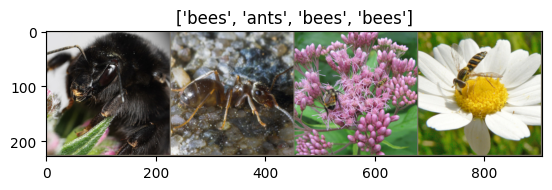

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# Variational quantum circuit

We first define some quantum layers that will compose the quantum circuit.


In [8]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Now we define the quantum circuit through the PennyLane qnode decorator .

The structure is that of a typical variational quantum circuit:

- **Embedding layer**: All qubits are first initialized in a balanced superposition of _up_ and _down_ states, then they are rotated according to the input parameters (local embedding).

- **Variational layers**: A sequence of trainable rotation layers and constant entangling layers is applied.

- **Measurement layer**: For each qubit, the local expectation value of the **_Z_** operator is measured. This produces a classical output vector, suitable for additional post-processing.


In [9]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

# Visualizing the VQC

## --- Step 1: Initial State ---

The initial state of the circuit shows just a Hadamard layer applied to all qubits. This creates a |+> state, which is a uniform superposition across all possible states of the four qubits.

## --- Step 2: Input Feature Embedding ---

The second step is feature embedding. Here we encode the classical inputs into the quantum state using a layer of RY rotations. This allows the quantum circuit to process the data into a classification between ants and bees.

## --- Step 3: Variational Layers ---

The third step shows the variational layers, which does the actual processing of input in order to make a prediction. This layer is composed of a sequence of entangling (CNOT) and rotation (RY) gates. This adds complexity to the model (more variational layers means more complexity) to be able to find subtle patterns in the input.

## --- Stage 5: Measurement Layer ---

The final stage is the measurement layer, which brings the altered quantum states back to classical data so that we can make sense of the output of the quantum circuit.


Let's visualize this.


In [10]:
# Dummy inputs
features = np.random.rand(n_qubits)
weights = np.random.rand(q_depth * n_qubits)  # Ensure weights have the correct size

# Visualize the quantum circuit at intermediate states using qml.draw()

# Initial step: Before embedding the input features
print("Quantum Circuit - Initial State (Only |+> state prepared):")
print(qml.draw(quantum_net)(np.zeros(n_qubits), np.zeros(q_depth * n_qubits)))
print("\n")

# After embedding the input features
print("Quantum Circuit - After Embedding Input Features:")
print(qml.draw(quantum_net)(features, np.zeros(q_depth * n_qubits)))
print("\n")

# After the first variational layer
print("Quantum Circuit - After First Variational Layer:")
print(qml.draw(quantum_net)(features, weights[:n_qubits * q_depth].reshape(q_depth, n_qubits)))
print("\n")

# After the entire circuit
print("Quantum Circuit - Final State (Full Variational Circuit):")
print(qml.draw(quantum_net)(features, weights))

Quantum Circuit - Initial State (Only |+> state prepared):
0: ──H──RY(0.00)─╭●──RY(0.00)───────────╭●──RY(0.00)───────────╭●──RY(0.00)───────────╭● ···
1: ──H──RY(0.00)─╰X─╭●─────────RY(0.00)─╰X─╭●─────────RY(0.00)─╰X─╭●─────────RY(0.00)─╰X ···
2: ──H──RY(0.00)─╭●─╰X─────────RY(0.00)─╭●─╰X─────────RY(0.00)─╭●─╰X─────────RY(0.00)─╭● ···
3: ──H──RY(0.00)─╰X──RY(0.00)───────────╰X──RY(0.00)───────────╰X──RY(0.00)───────────╰X ···

0: ··· ──RY(0.00)───────────╭●──RY(0.00)───────────╭●──RY(0.00)───────────┤  <Z>
1: ··· ─╭●─────────RY(0.00)─╰X─╭●─────────RY(0.00)─╰X─╭●─────────RY(0.00)─┤  <Z>
2: ··· ─╰X─────────RY(0.00)─╭●─╰X─────────RY(0.00)─╭●─╰X─────────RY(0.00)─┤  <Z>
3: ··· ──RY(0.00)───────────╰X──RY(0.00)───────────╰X──RY(0.00)───────────┤  <Z>


Quantum Circuit - After Embedding Input Features:
0: ──H──RY(0.18)─╭●──RY(0.00)───────────╭●──RY(0.00)───────────╭●──RY(0.00)───────────╭● ···
1: ──H──RY(0.78)─╰X─╭●─────────RY(0.00)─╰X─╭●─────────RY(0.00)─╰X─╭●─────────RY(0.00)─╰X ···
2: ──H

Above, we can see that there is a Hadamard layer, with everything after it set to zero. This is the initial state of the circuit. (We have created this by passing zero-features and zero-weights to the model.)

Then the second output shows the feature embedding, which shows non-zero rotations in the first rotation layer after the Hadamard gates.

Then the third output shows the variational layers, which shows non-zero rotations in the variational layers of the circuit, after the initial Hadamard and feature embedding (rotation) layers.

## Step-by-step visualization of building the circuit

Below is a visualization of how the circuit is built step-by-step through sequential images.


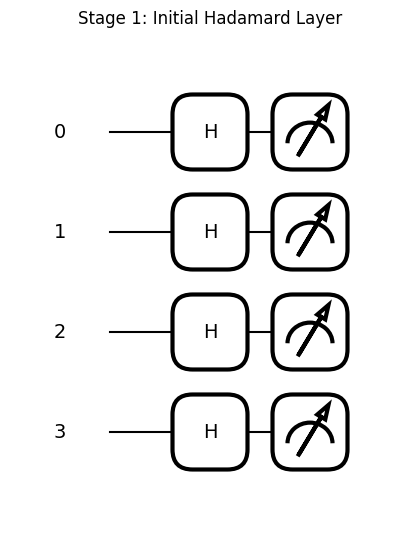

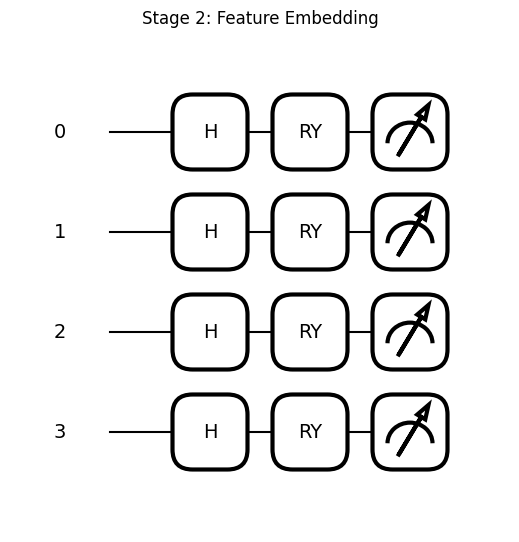

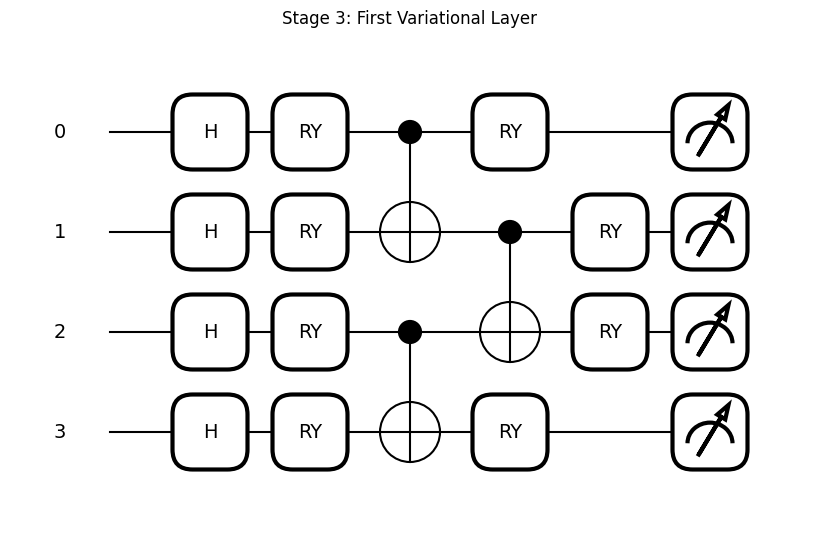

c:\Users\evren\anaconda3\envs\workshop\Lib\site-packages\pennylane\math\interface_utils.py:136: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


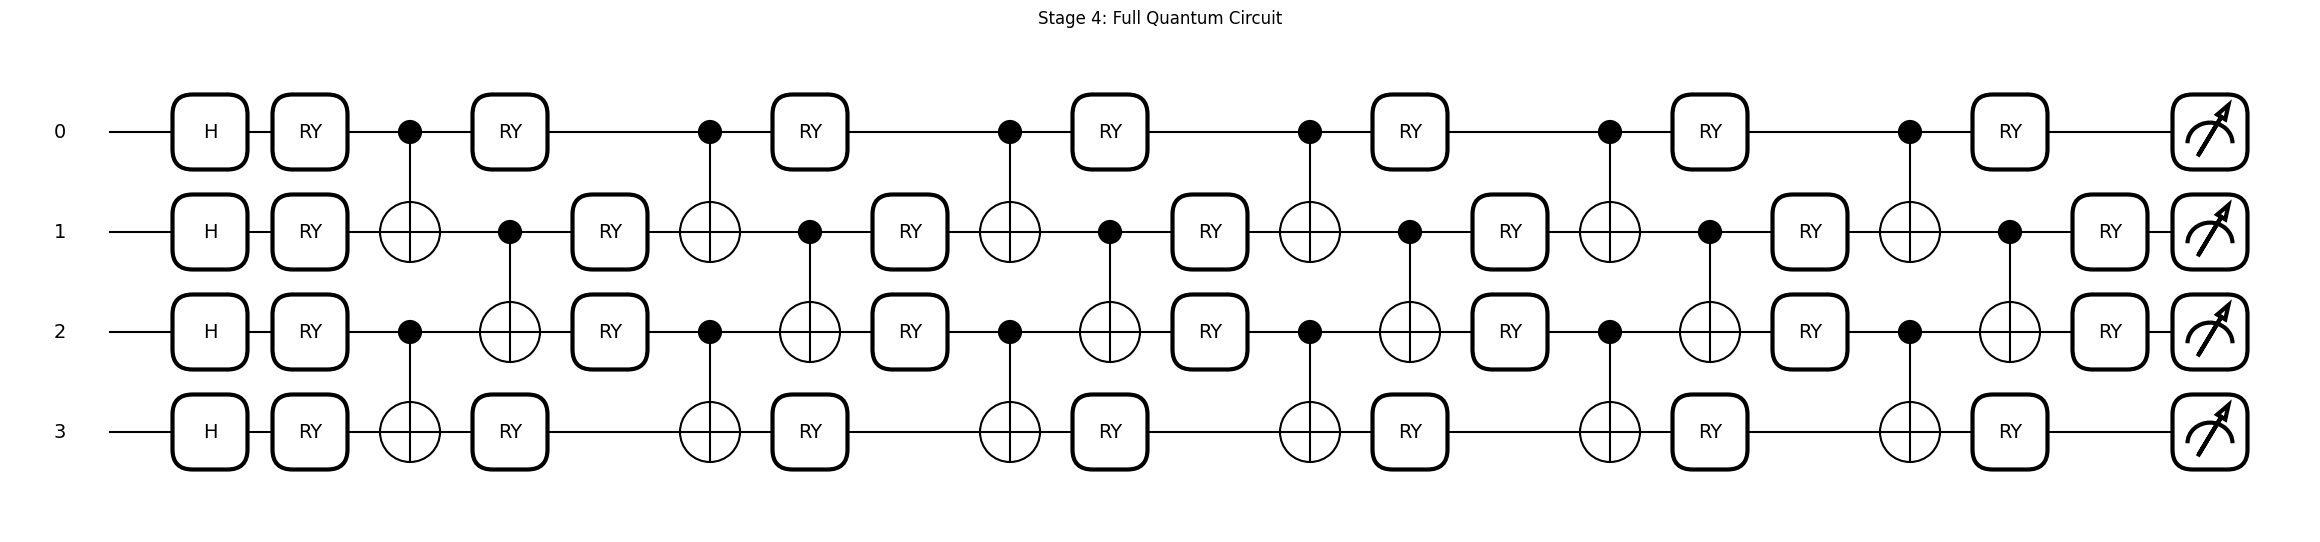

In [11]:
import matplotlib.pyplot as plt # Ensure matplotlib is imported

# Dummy inputs
features = np.random.rand(n_qubits)
weights_flat = np.random.rand(q_depth * n_qubits)
weights = weights_flat.reshape(q_depth, n_qubits)
weights_torch = torch.tensor(weights_flat, dtype=torch.float64, requires_grad=True) # Use torch tensor for consistency if needed later

# --- Stage 1: Initial Hadamard Layer ---
@qml.qnode(dev)
def circuit_stage1():
    H_layer(n_qubits)
    # Add dummy measurements for drawing if needed, or draw without them
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

fig1, ax1 = qml.draw_mpl(circuit_stage1)()
ax1.set_title("Stage 1: Initial Hadamard Layer")
plt.show()


# --- Stage 2: Feature Embedding ---
@qml.qnode(dev)
def circuit_stage2(q_input_features):
    H_layer(n_qubits)
    RY_layer(q_input_features)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

fig2, ax2 = qml.draw_mpl(circuit_stage2)(features)
ax2.set_title("Stage 2: Feature Embedding")
plt.show()


# --- Stage 3: First Variational Layer ---
@qml.qnode(dev)
def circuit_stage3(q_input_features, q_weights_layer1):
    H_layer(n_qubits)
    RY_layer(q_input_features)
    # First variational layer
    entangling_layer(n_qubits)
    RY_layer(q_weights_layer1)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

fig3, ax3 = qml.draw_mpl(circuit_stage3)(features, weights[0]) # Pass only the first layer's weights
ax3.set_title("Stage 3: First Variational Layer")
plt.show()


# --- Stage 4: Full Circuit ---
# Use the original quantum_net for the full visualization
fig4, ax4 = qml.draw_mpl(quantum_net)(features, weights_torch) # Use the original QNode
ax4.set_title("Stage 4: Full Quantum Circuit")
plt.show()

# Dressed quantum circuit

We can now define a custom `torch.nn.Module` representing a _dressed_ quantum circuit.

This is a concatenation of:

- A classical pre-processing layer (`nn.Linear`).

- A classical activation function (`torch.tanh`).

- A constant np.pi/2.0 scaling.

- The previously defined quantum circuit (`quantum_net`).

A classical post-processing layer (`nn.Linear`).

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: _ants_ and _bees_).


Added dropout after pre_net, after post_net, and before tanh

In [12]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """
        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits) 
        self.dropout_pre = nn.Dropout(p=0.1)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)
        self.dropout_post = nn.Dropout(p=0.1)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        pre_out = self.dropout_pre(pre_out)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        # q_out = self.dropout_post(q_out) NO NEED
        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

# Hybrid classical-quantum model

We are finally ready to build our full hybrid classical-quantum network. We follow the _transfer_ learning approach:

1. First load the classical pre-trained network _ResNet18_ from the `torchvision.models` zoo.

2. Freeze all the weights since they should not be trained.

3. Replace the last fully connected layer with our trainable dressed quantum circuit (`DressedQuantumNet`).

> **Note**<br>
> The ResNet18 model is automatically downloaded by PyTorch and it may take several minutes (only the first time).


In [13]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

# Training and results

Before training the network we need to specify the _loss_ function.

We use, as usual in classification problem, the _cross-entropy_ which is directly available within `torch.nn`.


In [14]:
criterion = nn.CrossEntropyLoss()

We also initialize the Adam optimizer which is called at each training step in order to update the weights of the model.


In [15]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every 10 epochs.


In [16]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

What follows is a training function that will be called later. This function should return two things:

1. a trained model that can be used to make predictions (classifications)

2. the accuracy of the model on two datasets (training & validation) to see if our model's generalizable (can classify images we didn't use to train it).


In [17]:
%pip install torchmetrics seaborn
import seaborn as sns

from torchmetrics.classification import BinaryConfusionMatrix
metric = BinaryConfusionMatrix()
from torchmetrics.classification import ConfusionMatrix
confmat = ConfusionMatrix(task="multiclass", num_classes=2).to(device)

#Function for plotting confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, normalize, title):
    """
    Plots a confusion matrix using Seaborn.

    Parameters:
    
    conf_matrix (Tensor or ndarray): Confusion matrix (NxN)
    class_names (list): Names of classes for axis ticks
    normalize (bool): Whether to normalize the values by row
    """
    if isinstance(conf_matrix, torch.Tensor):
        conf_matrix = conf_matrix.cpu().numpy()

    if normalize:
        conf_matrix = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
   ---------------------------------------- 0.0/961.5 kB ? eta -:--:--
   ---------------------------------------- 961.5/961.5 kB 6.4 MB/s eta 0:00:00
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)

   ---------------------------------------- 0/6 [pytz]
   ---------------------------------------- 0/6 [pytz]
   ------ --------------------------------- 1/6 [tzdata]
   ------ --------------------------------- 1/6 [tzdata]
   ------ --------------------------------- 1/6 [tzdata]
   -------------------- ------------------- 3/6 [pandas]
   -------------------- ------------------- 3/6 [pandas]
   -------------------- ------------------- 3/6 [pandas]
   -------------------- ------------------- 3/6 [pandas]
   -------------------- ------------------- 3/6 [pandas]
   -------------------- ------------------- 3/6 [pandas]
   -------------------- ------------------- 3/6 [pandas]
   -------------------- -----------

In [18]:
# This function trains a PyTorch model and returns the best version + a training history
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()  # Record the starting time of training

    # Save the model's initial weights so we can restore the best version later
    best_model_wts = copy.deepcopy(model.state_dict())

    # Initialize variables to track the best performance
    best_acc = 0.0
    best_loss = float("inf")  # Set to a very high number initially

    training_step_count = 0
    validation_step_count = 0

    # Dictionary to keep track of training and validation loss/accuracy over time
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "train_step_loss": [],
        "train_step_acc": [],
        "val_step_loss": [],
        "val_step_acc": []
    }

    print("Training started:\n")

    # Loop through the number of epochs (full passes through the dataset)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")  # Print current epoch number

        # Each epoch has two phases: training and validation
        for phase in ["train", "validation"]:
            # Set the model to training mode (enables dropout, batchnorm, etc.)
            if phase == "train":
                model.train()
            # Set the model to evaluation mode (turns off dropout, batchnorm, etc.)
            else:
                model.eval()

            # Initialize loss and accuracy counters for this phase
            running_loss = 0.0
            running_corrects = 0

            # Loop over the batches of data
            for inputs, labels in dataloaders[phase]:

                # Move inputs and labels to the GPU (or CPU) device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradients so we don't accumulate from previous steps
                optimizer.zero_grad()

                # Enable gradient tracking only in the training phase
                with torch.set_grad_enabled(phase == "train"):
                    # Forward pass: get model predictions
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Get predicted class
                    loss = criterion(outputs, labels)  # Calculate loss

                    # Backward pass + optimize only if in training phase
                    if phase == "train":
                        loss.backward()      # Compute gradients
                        optimizer.step()     # Update weights
                
                # Calculate average loss and accuracy for the step
                step_loss = loss.item() * inputs.size(0)
                step_corrects = torch.sum(preds == labels.data).item()
                step_acc = step_corrects / inputs.size(0)

                # Save metrics to history
                if phase == "train":
                    training_step_count += 1
                    history["train_step_loss"].append(step_loss)
                    history["train_step_acc"].append(step_acc)
                    scheduler.step()  # Adjust learning rate
                else:
                    validation_step_count += 1
                    history["val_step_loss"].append(step_loss)
                    history["val_step_acc"].append(step_acc)

                # Accumulate loss and correct predictions for the entire phase
                running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
                running_corrects += torch.sum(preds == labels.data).item()

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Print the results for this phase
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save metrics to history and step the scheduler if training
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
                scheduler.step()  # Adjust learning rate
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)

                # Save the model if this is the best validation accuracy so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    # Plot training accuracy and loss per epoch
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), history["train_acc"], label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), history["train_loss"], label="Training Loss")
    plt.plot(range(1, num_epochs + 1), history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    plt.show()

    # Plot training accuracy and loss per step
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, training_step_count + 1), history["train_step_acc"], label="Training Accuracy")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training Accuracy over Steps")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, training_step_count + 1), history["train_step_loss"], label="Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss over Steps")

    plt.show()

    # Plot validation accuracy and loss per step
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, validation_step_count + 1), history["val_step_acc"], label="Validation Accuracy", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy over Steps")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, validation_step_count + 1), history["val_step_loss"], label="Validation Loss", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Validation Loss over Steps")

    plt.show()

    # Confusion matrix
    cmatrix = confmat.compute()
    print("Confusion matrix: ")
    print(cmatrix)
    plot_confusion_matrix(cmatrix, ["Ants", "Bees"], False, "Confusion Matrix")
    plt.show()

    # Print total training time
    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")

    # Load the best model weights into the model before returning
    model.load_state_dict(best_model_wts)
    return model, history  # Return the best model and the training history

We are ready to perform the actual training process and store the generalization data.


Training started:

Epoch 1/3
Train Loss: 0.7042 Acc: 0.4795
Validation Loss: 0.7131 Acc: 0.4379
Epoch 2/3
Train Loss: 0.6928 Acc: 0.5492
Validation Loss: 0.7153 Acc: 0.4379
Epoch 3/3
Train Loss: 0.6997 Acc: 0.4877
Validation Loss: 0.7160 Acc: 0.4510


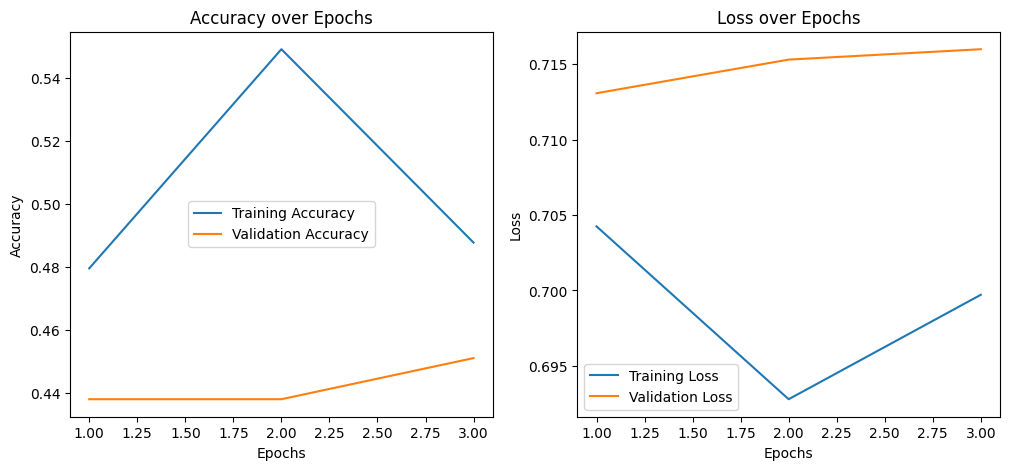

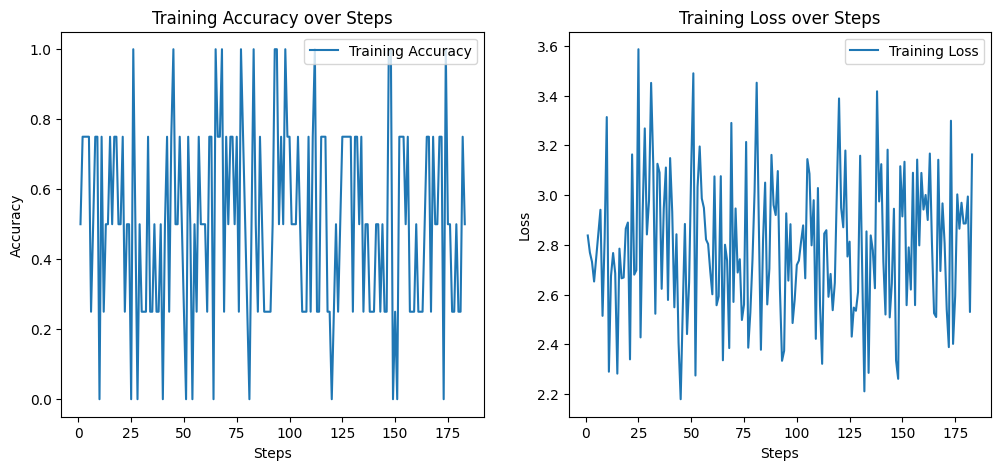

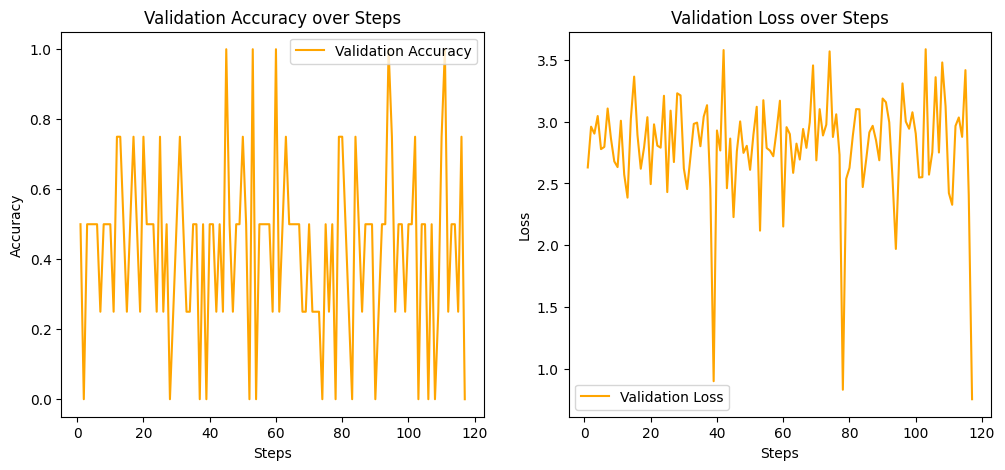

c:\Users\evren\anaconda3\envs\workshop\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Confusion matrix: 
tensor([[0, 0],
        [0, 0]])


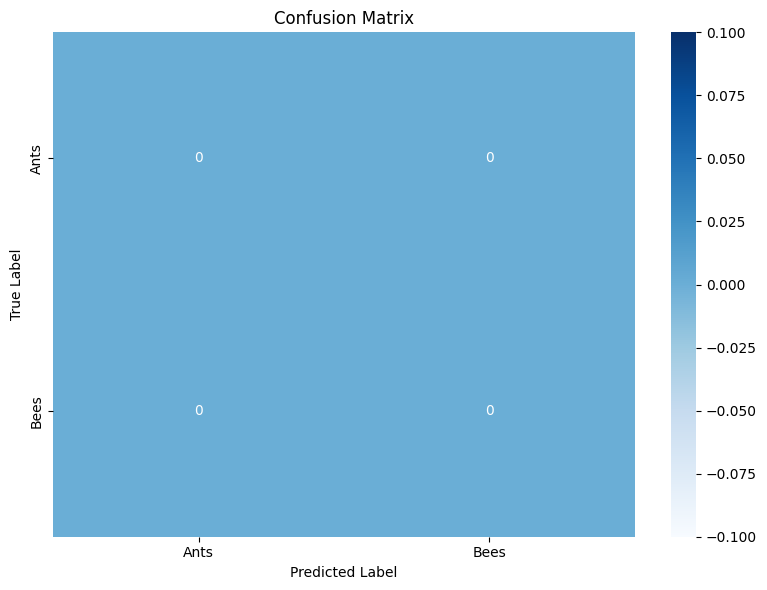


Training complete in 1m 37s
Best validation accuracy: 0.4510


In [26]:
model_hybrid, history = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

In [20]:
# Plot training and validation loss
plt.figure("Training and Validation Loss")
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.plot(history["train_acc"], label="Training Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

# Visualizing the model Predications

We first define a visualization function for a batch of test data.


In [22]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

Finally, we can run the previous function to see a batch of images with the corresponding predictions.


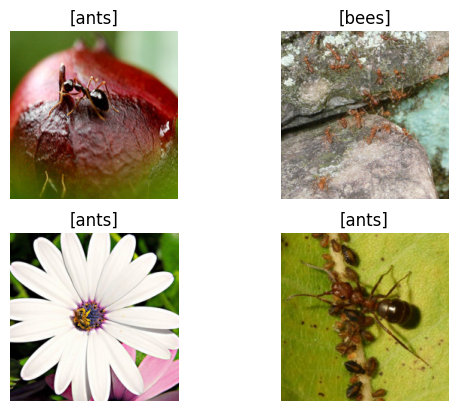

In [23]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()

# References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. Transfer learning in hybrid classical-quantum neural networks. arXiv:1912.08278 (2019).

[2] Rajat Raina, Alexis Battle, Honglak Lee, Benjamin Packer, and Andrew Y Ng. Self-taught learning: transfer learning from unlabeled data. Proceedings of the 24th International Conference on Machine Learning\*, 759–766 (2007).

[3] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. Deep residual learning for image recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016).

[4] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. arXiv:1811.04968 (2018).

[5] Andrea Mari. Quantum Transfer Learning. https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning (2024)
